# Implementation of Fast RCNN 

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
import pandas as pd
from tqdm import tqdm
import timeit
import time
from skimage import transform, io
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
import os
from __future__ import division, print_function
import shutil
%matplotlib inline
import glob
import torchvision.transforms as T
from torchvision import utils
import scipy.misc as m

In [4]:
# Reading in the pascal voc dataset

# We are using the pascal voc 2007 dataset for this implementation

train_list = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2007/ImageSets/Layout/train.txt'

def get_images(file):
    train_images = []
    f = open(file, 'r')
    filecontents = f.readlines()
    for line in filecontents:
        img_name = line.strip("\n")
        train_images.append(img_name)
    return train_images

In [5]:
train_images = get_images(train_list)
print(len(train_images))

318


In [7]:
# Get the actual images and create a train_images folder
images_dir = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2007/JPEGImages'

if not os.path.exists('/Users/navneetmkumar/Documents/Paper Implementations/train-inputs'):
    os.makedirs('/Users/navneetmkumar/Documents/Paper Implementations/train-inputs')
    
new_images_dir = '/Users/navneetmkumar/Documents/Paper Implementations/train-inputs'
    
def copyFiles(directory, target_dir):
    for f in os.listdir(directory):
        f_name = os.path.basename(f)
        f_name = f_name.split(".")[0]
        if f_name in train_images:
            f = os.path.join(directory, f)
            shutil.copy2(f, target_dir)

In [8]:
copyFiles(images_dir, new_images_dir)

In [16]:
# Creating the target arrays for each of the images
targets = []

targets_list = '/Users/navneetmkumar/Documents/Paper Implementations/VOC2007/ImageSets/Main'


# Get all the train txt files
train_txt_files = sorted(glob.glob(os.path.join(targets_list, '*_train.txt')))
print(len(train_txt_files))

20


In [63]:
targets = []
# Iterate through the train txt files and create the corresponding tensor for each image in new images dir
new_images_dir = '/Users/navneetmkumar/Documents/Paper Implementations/train-inputs'
for f in os.listdir(new_images_dir):
    target = np.zeros(len(train_txt_files))
    f_name = os.path.basename(f)
    f_name = f_name.split(".")[0]
    for i,t in enumerate(train_txt_files):
        t = open(t, 'r')
        filecontents = t.readlines()
        for fc in filecontents:
            c = fc
            a = fc.split(" ")[0]
            b = fc.split(" ")[1]
            if b == '':
                b = c.split("  ")[1]  
            b = b.strip("\n")
            if a == f_name:
                if b=='1':
                    target[i]=1
    targets.append(target)

In [64]:
print(len(targets))

318


In [67]:
targets[312]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [116]:
# Defining the detection dataset
class DetectionDataset(Dataset):
    
    #Initialize the dataset
    def __init__(self, train_list, train_targets, img_size = 512, is_transform=False):
        self.train_list = train_list
        self.train_targets = train_targets
        self.img_size = img_size if isinstance(img_size, tuple) else (img_size, img_size)
        self.is_transform = is_transform
        self.mean = np.array([104.00699, 116.66877, 122.67892])
        
        
    def __len__(self):
        return len(self.train_targets)
    
    def transform(self, sample):
        img = sample['image']
        lbl = sample['label']
        img = img[:, :, ::-1]
        img = img.astype(np.float64)
        img -= self.mean
        img = m.imresize(img, (self.img_size[0], self.img_size[1]))
        # Resize scales images from 0 to 255, thus we need
        # to divide by 255.0
        img = img.astype(float) / 255.0
        # NHWC -> NCWH
        img = img.transpose(2, 0, 1)
        
        img = torch.from_numpy(img).float()
        lbl = torch.from_numpy(lbl).long()
        
        sample  = {'image': img, 'label': lbl}
        return sample
        
    def __getitem__(self, i):
        image_name = "/Users/navneetmkumar/Documents/Paper Implementations/train-inputs/"+self.train_list[i]+".jpg"
        image = m.imread(image_name)
        target = self.train_targets[i]
        sample = {'image':image, 'label': target}
        if self.is_transform:
            sample = self.transform(sample)
        return sample
     

In [117]:
data = DetectionDataset(train_images, targets, is_transform=True)

In [118]:
# Instead of using a simple for loop we will be using the torch.utils.DataLoader
# It provides the following features:
# 1.Batching the data
# 2.Shuffling the data
# 3.Load data in parallel using multiprocessing workers

dataloader = DataLoader(data, batch_size=5, shuffle=True, num_workers=4)

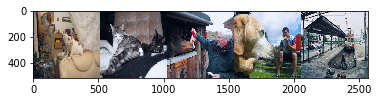



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     1     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 19 
    0     1     0     0     0     0     1
    0     1     0     0     0     0     1
    1     1     0     0     0     0     0
    0     1     0     0     0     0     0
    1     0     0     0     0     0     0
[torch.LongTensor of size 5x20]



In [120]:
for i_batch, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
    if i_batch == 0:
        img = torchvision.utils.make_grid(image).numpy()
        img = np.transpose(img, (1, 2, 0))
        img = img[:, :, ::-1]
        plt.imshow(img)
        plt.show()
        print(target)